In [1]:
# charger l'extension autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# chargement
import pandas as pd
from sklearn.compose import make_column_selector

learn_dataset = pd.read_csv('data/raw/learn_dataset.csv')
test_dataset = pd.read_csv('data/raw/test_dataset.csv')
learn_dataset_job = pd.read_csv('data/raw/learn_dataset_job.csv')
test_dataset_job = pd.read_csv('data/raw/test_dataset_job.csv')
learn_dataset_emp = pd.read_csv('data/raw/learn_dataset_emp.csv')
test_dataset_emp = pd.read_csv('data/raw/test_dataset_emp.csv')
learn_dataset_retired_former = pd.read_csv('data/raw/learn_dataset_retired_former.csv')
test_dataset_retired_former = pd.read_csv('data/raw/test_dataset_retired_former.csv')
learn_dataset_retired_pension = pd.read_csv('data/raw/learn_dataset_retired_pension.csv')
test_dataset_retired_pension = pd.read_csv('data/raw/test_dataset_retired_pension.csv')
learn_dataset_retired_jobs = pd.read_csv('data/raw/learn_dataset_retired_jobs.csv')
test_dataset_retired_jobs = pd.read_csv('data/raw/test_dataset_retired_jobs.csv')
city_adm = pd.read_csv('data/raw/city_adm.csv')
departments = pd.read_csv('data/raw/departments.csv')
city_pop = pd.read_csv('data/raw/city_pop.csv')
city_loc = pd.read_csv('data/raw/city_loc.csv')
learn_dataset_sport = pd.read_csv('data/raw/learn_dataset_sport.csv')
test_dataset_sport = pd.read_csv('data/raw/test_dataset_sport.csv')

# Identifier les colonnes
categorical_columns = make_column_selector(dtype_include=['object'])
numeric_columns = make_column_selector(dtype_include=['number'])
boolean_columns = make_column_selector(dtype_include=['bool'])

In [ ]:
# # (Non retenu) pour ajouter la distance à la préfecture
# learn_dataset['distance_pref'] = learn_dataset_distance['distance_pref']

# Commentaire : les résultats sont presque identiques avec et sans cette variable (légère baisse des performances en validation avec *distance_pref*).

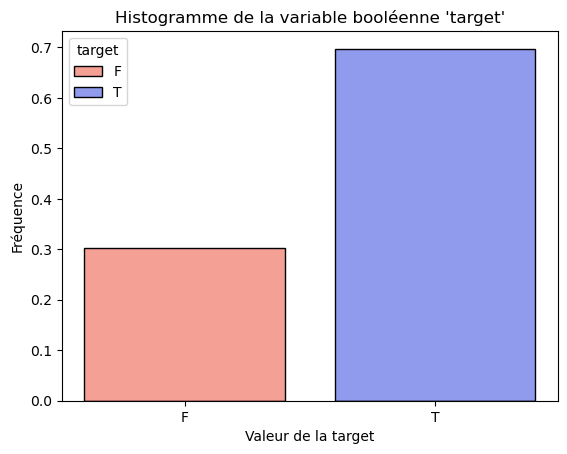

In [ ]:
# Affichage histogramme de la variable booléenne 'target'

import seaborn as sns
import matplotlib.pyplot as plt

# Liste des couleurs pour chaque barre
palette = ["#ec422b", "#2238dc"]  # Bleu et Orange (ou choisissez vos propres couleurs)

# Configuration de l'histogramme avec Seaborn
sns.histplot(data=learn_dataset, 
             x="target", 
             bins=2,  # Deux catégories pour booléen
             color=None, 
             hue="target",  # Sépare les deux valeurs par couleur
             palette=palette,  # Utilise une palette spécifique
             shrink=0.8,
             stat="probability"  # Légèremment rétrécir les barres pour créer un espace
            )

# Définir un titre et les labels des axes
plt.title("Histogramme de la variable booléenne 'target'")
plt.xlabel("Valeur de la target")
plt.ylabel("Fréquence")

# Sauvegarder le graphique dans le dossier "image/" au format PNG
output_path = "images/histogramme_target.png"  # Chemin du fichier de sortie
plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

# Affichage de la figure
plt.show()


# Entraînement des différents modèles

## Modèle *all*

In [3]:
# Fusion de learn_dataset et learn_dataset_job  

from pipelines_preprocessing.pipeline_all import prepare_all_pipeline

# Utilisation de la fonction avec les données d'entrée
X_train, X_val, y_train, y_val = prepare_all_pipeline(
    learn_dataset=learn_dataset,
    learn_dataset_sport=learn_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    test_size=0.2,  
    random_state=11,  
    stratify=True,  
    remove_columns=['Unique_id', 'Insee']  # Colonnes à supprimer
)

### RF *all*

Entraînement du modèle avec GridSearchCV...
Nombre de variables après preprocessing : 283

Meilleurs paramètres trouvés : {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Affichage des matrices de confusion...
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
train roc_auc: 0.9281
val roc_auc: 0.8257
train accuracy: 0.8604
Val accuracy: 0.8619
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.73      0.76      3028
        True       0.89      0.92      0.90      6981

    accuracy                           0.86     10009
   macro avg       0.84      0.83      0.83     10009
weighted avg       0.86      0.86   

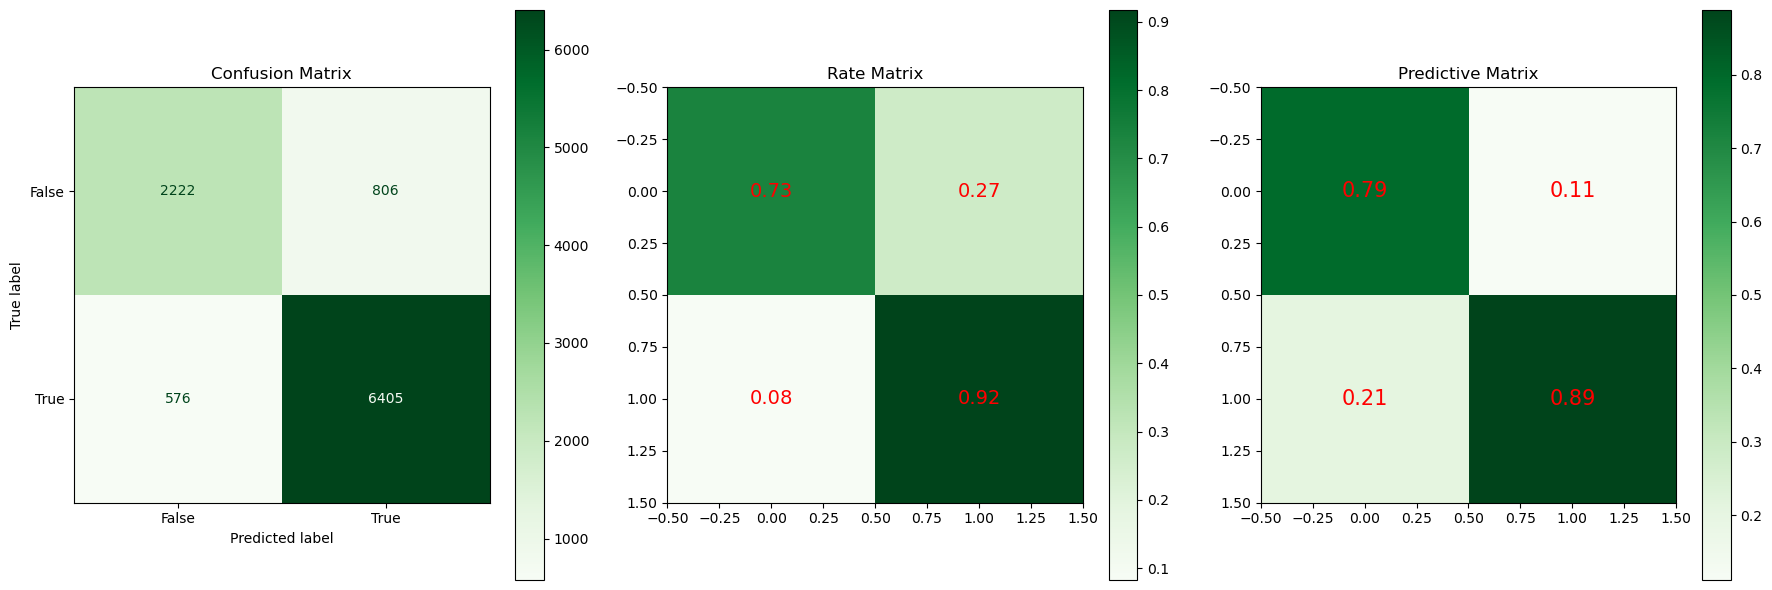

In [11]:
from models.pipeline_RF_all import RF_all

# Appel de la fonction pour entraîner et afficher les résultats
RF_all_best = RF_all(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)   

#### shap RF *all*

In [ ]:
import shap
import numpy as np
# Séparer le préprocesseur et le modèle
preprocessor = RF_all_best.named_steps['preprocessor']
model = RF_all_best.named_steps['classifier']

# Appliquer les transformations du préprocesseur sur X_val
X_val_transformed = preprocessor.transform(X_val)

# Récupérer les noms des colonnes après transformation
feature_names = preprocessor.named_steps['column_transformer'].get_feature_names_out()

# Convertir les données transformées en DataFrame avec les bons noms de colonnes
import pandas as pd
X_val_dense = pd.DataFrame(X_val_transformed.toarray(), columns=feature_names)

# Prendre un échantillon aléatoire de 1000 observations
sample_size = 5000
X_val_dense_sample = X_val_dense.sample(n=sample_size, random_state=11).reset_index(drop=False)

# Créer un explainer 
explainer = shap.Explainer(model)

# Calculer les valeurs SHAP uniquement sur l'échantillon (en spécifiant check_additivity=False pour les grands modèles)
shap_values_sample = explainer.shap_values(X_val_dense, check_additivity=False)

shap_values_selected = shap_values_sample[:, :, 1]  # Sélectionner la classe 1

# Calcul des importances SHAP globales (valeur absolue moyenne)
shap_importance = pd.DataFrame({
    'feature': X_val_dense.columns,          # Les noms des features (colonnes du dataset après transformation)
    'shap_importance': np.abs(shap_values_selected).mean(axis=0)  # Moyenne des valeurs SHAP absolues
})

# Tri décroissant en fonction des valeurs d'importance SHAP
sorted_shap_importance = shap_importance.sort_values(by='shap_importance', ascending=False)


 All (636 minutes)

In [9]:
import numpy as np
#### Sauvegarde des résultats sur l'ensemble des données
# shap_values_all = shap_values_sample   # sauvegarde du résultat all
# shap_values_selected_all = shap_values_selected  # sauvegarde du résultat all
# sorted_shap_importance_all = sorted_shap_importance   # sauvegarde du résultat all

# np.save('outputs/shap_values/shap_values_RF_all.npy', shap_values_all)
loaded_shap_values_RF_all = np.load('outputs/shap_values/shap_values_all.npy')
# np.save('outputs/shap_values/shap_values_selected_all.npy', shap_values_selected_all)
shap_values_selected_RF_all = np.load('outputs/shap_values/shap_values_selected_all.npy')

#sorted_shap_importance_all.to_csv('outputs/shap_values/sorted_shap_importance_RF_all.csv', index=False)
sorted_shap_importance_RF_all = pd.read_csv('outputs/shap_values/sorted_shap_importance_all.csv')

# X_val_dense.to_csv('outputs/shap_values/X_val_dense_RF.csv', index=False)
X_val_dense_RF = pd.read_csv('outputs/shap_values/X_val_dense.csv')

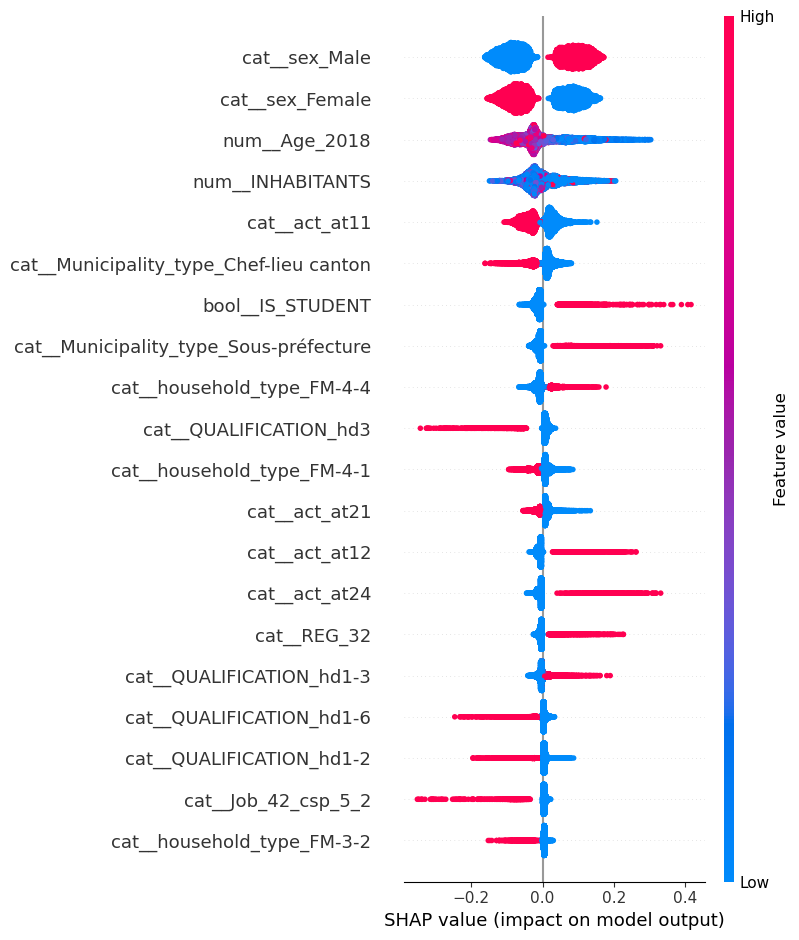

In [ ]:
shap.summary_plot(shap_values_selected_RF_all, X_val_dense, show=True)

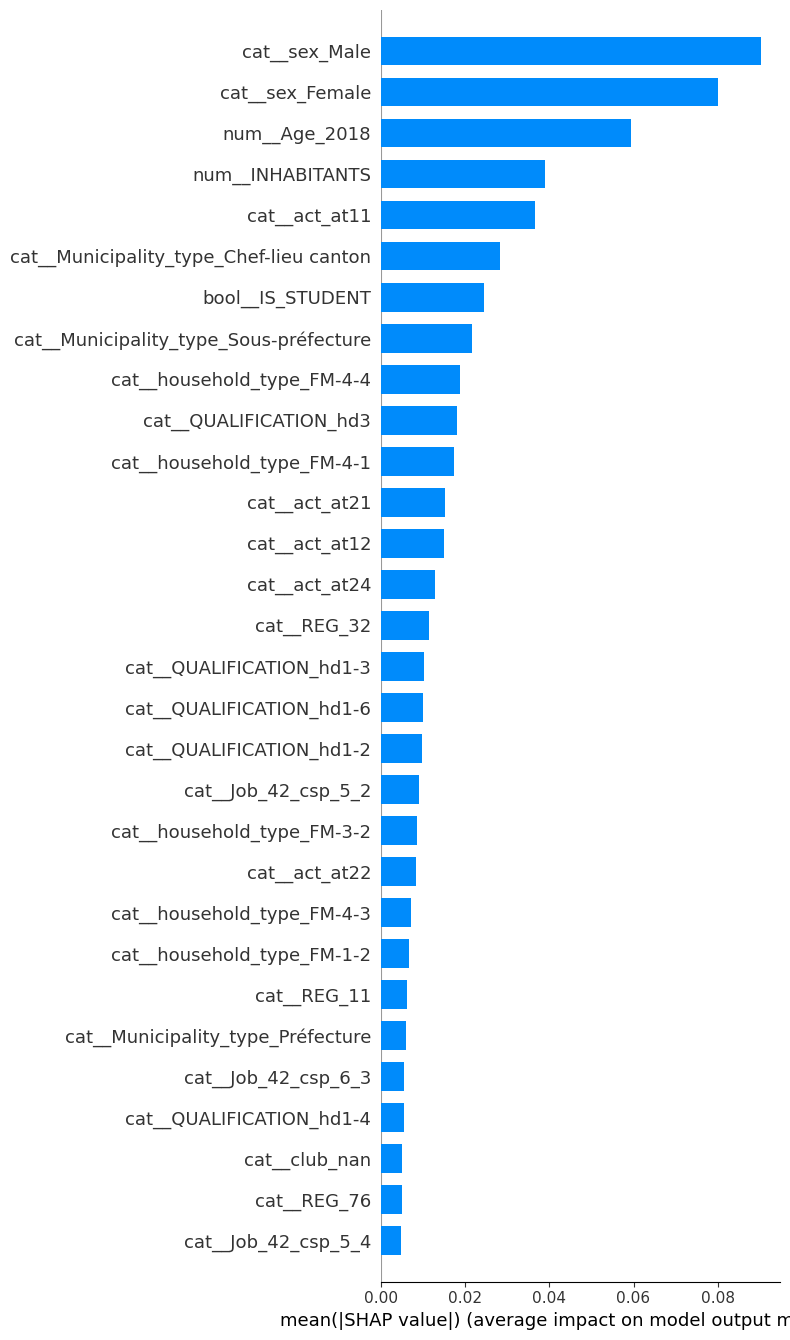

In [ ]:
shap.summary_plot(
    shap_values_selected_RF_all,
    X_val_dense,
    plot_type="bar",
    max_display=30,  # Ajustez ce chiffre selon vos besoins
    show=False
)

 All sans Job_dep (792 minutes)

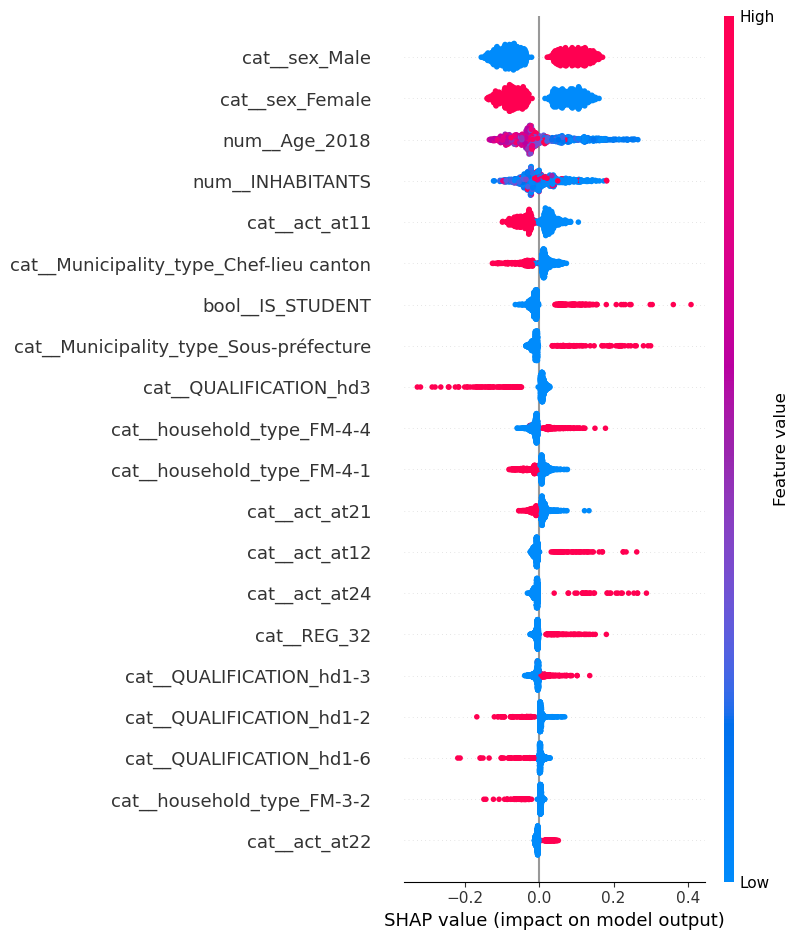

In [ ]:
# Visualiser les résultats

shap.summary_plot(shap_values_selected, X_val_dense_sample, show=True)

In [12]:
from pipelines_preprocessing.preprocess_for_shap import preprocess_for_shap
n_features_to_keep = 50
# Appliquer la fonction
X_train_shap, X_val_shap = preprocess_for_shap(X_train, X_val, categorical_columns, boolean_columns, numeric_columns, sorted_shap_importance_RF_all, n_features_to_keep)

Entraînement du modèle avec GridSearchCV...

Meilleurs paramètres trouvés : {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Meilleur score ROC-AUC : 0.9200956616943247

Affichage des matrices de confusion...
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
train roc_auc: 0.9201
val roc_auc: 0.8155
train accuracy: 0.8532
Val accuracy: 0.8522
Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.72      0.75      3028
        True       0.88      0.91      0.90      6981

    accuracy                           0.85     10009
   macro avg       0.83      0.82      0.82     10009
weighted avg       0.85      0.85     

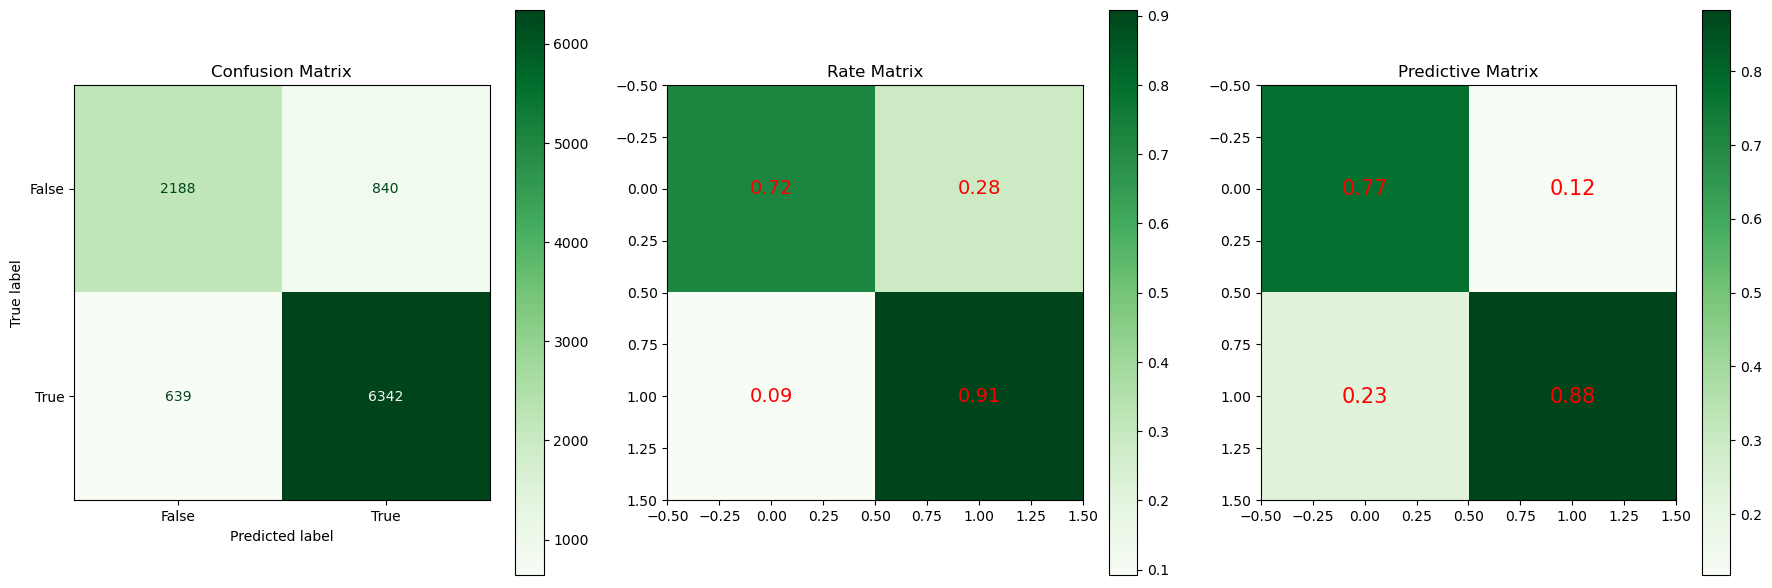

In [13]:
from models.pipeline_RF_all_shap import RF_all_shap

# Appel de la fonction pour entraîner et afficher les résultats
RF_all_shap_best = RF_all_shap(
    X_train_shap=X_train_shap,
    y_train=y_train,
    X_val_shap=X_val_shap,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

Conclusion: Résultats légèrement inférieur à ceux obtenus sans sélection de variables par Shap values.

### XGB *all*

Entraînement du modèle XGBoost avec GridSearchCV...
Nombre de variables après preprocessing : 283

Meilleurs paramètres trouvés : {'classifier__alpha': 0, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.5, 'classifier__lambda': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
Meilleur score roc_auc : 0.9488497462915794

Affichage des matrices de confusion...
Best parameters: {'classifier__alpha': 0, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.5, 'classifier__lambda': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
train roc_auc: 0.9488
val roc_auc: 0.8546
train accuracy: 0.8838
Val accuracy: 0.8826
Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.78      0.80      3028
        True       0.91      0.93      0.92      6981

    accuracy      

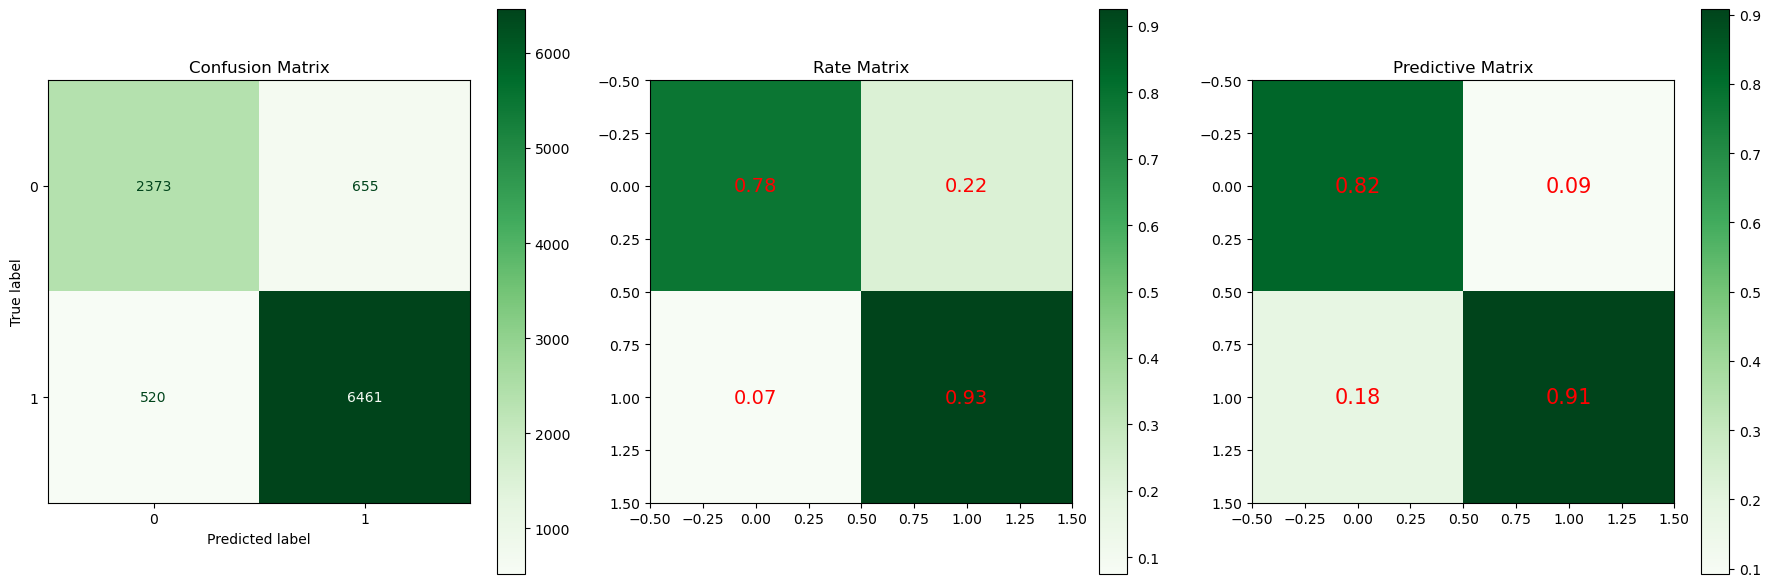

In [ ]:
from models.pipeline_XGB_all import XGB_all

# Appel de la fonction
XGB_all_best = XGB_all(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)


#### Shap XBB all

In [176]:
import shap
import numpy as np
# Séparer le préprocesseur et le modèle
preprocessor = XGB_all_best.named_steps['preprocessor']
model = XGB_all_best.named_steps['classifier']

# Appliquer les transformations du préprocesseur sur X_val
X_val_transformed = preprocessor.transform(X_val)

# Récupérer les noms des colonnes après transformation
feature_names = preprocessor.named_steps['column_transformer'].get_feature_names_out()

# Convertir les données transformées en DataFrame avec les bons noms de colonnes
import pandas as pd
X_val_dense_XGB_all = pd.DataFrame(X_val_transformed.toarray(), columns=feature_names)

# Créer un explainer 
explainer = shap.Explainer(model)

# Calculer les valeurs SHAP uniquement sur l'échantillon (en spécifiant check_additivity=False pour les grands modèles)
shap_values_XGB_all = explainer.shap_values(X_val_dense, check_additivity=True)

# Calcul des importances SHAP globales (valeur absolue moyenne)
shap_importance = pd.DataFrame({
    'feature': X_val_dense_XGB_all.columns,          # Les noms des features (colonnes du dataset après transformation)
    'shap_importance': np.abs(shap_values_XGB_all).mean(axis=0)  # Moyenne des valeurs SHAP absolues
})

# Tri décroissant en fonction des valeurs d'importance SHAP
sorted_shap_importance_XGB_all = shap_importance.sort_values(by='shap_importance', ascending=False)

In [ ]:
### Sauvegarde des résultats
# np.save('outputs/shap_values/shap_values_XGB_all.npy', shap_values_XGB_all)
loaded_shap_values_XGB_all = np.load('outputs/shap_values/shap_values_all.npy')

# X_val_dense_XGB_all.to_csv('outputs/shap_values/X_val_dense_XGB_all.csv', index=False)
X_val_dense_XGB = pd.read_csv('outputs/shap_values/X_val_dense_XGB.csv')

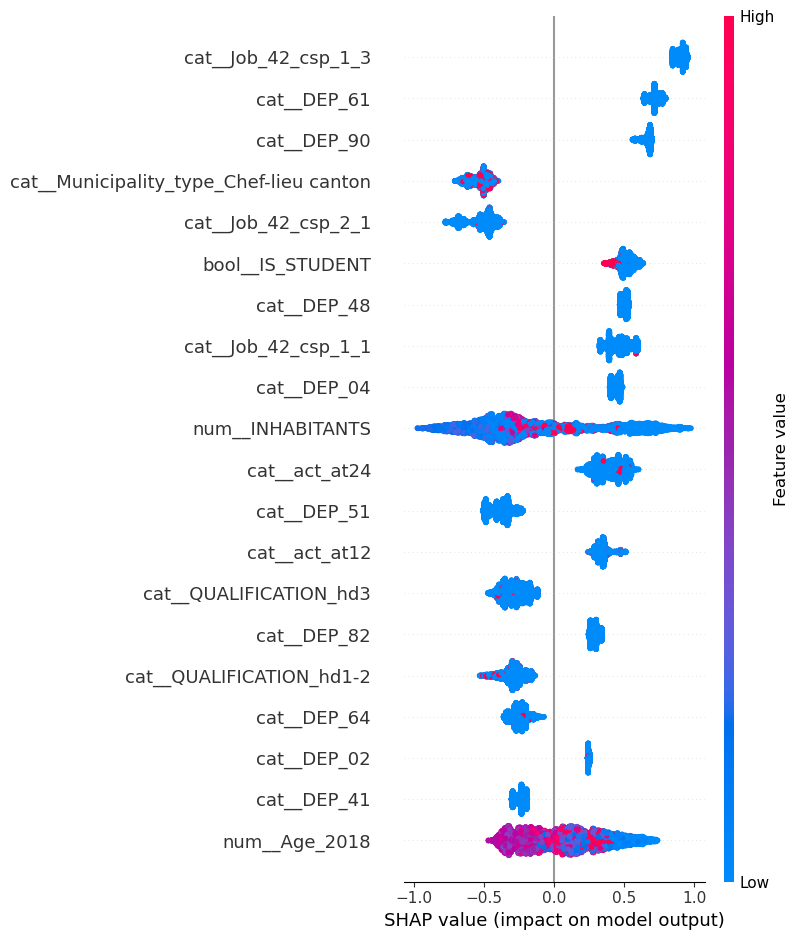

In [171]:
shap.summary_plot(shap_values_XGB_all, X_val_dense_XGB_all, show=True)

Notons que l'importance des variables est très différente de celle obtenue avec les valeurs Shap du RF.

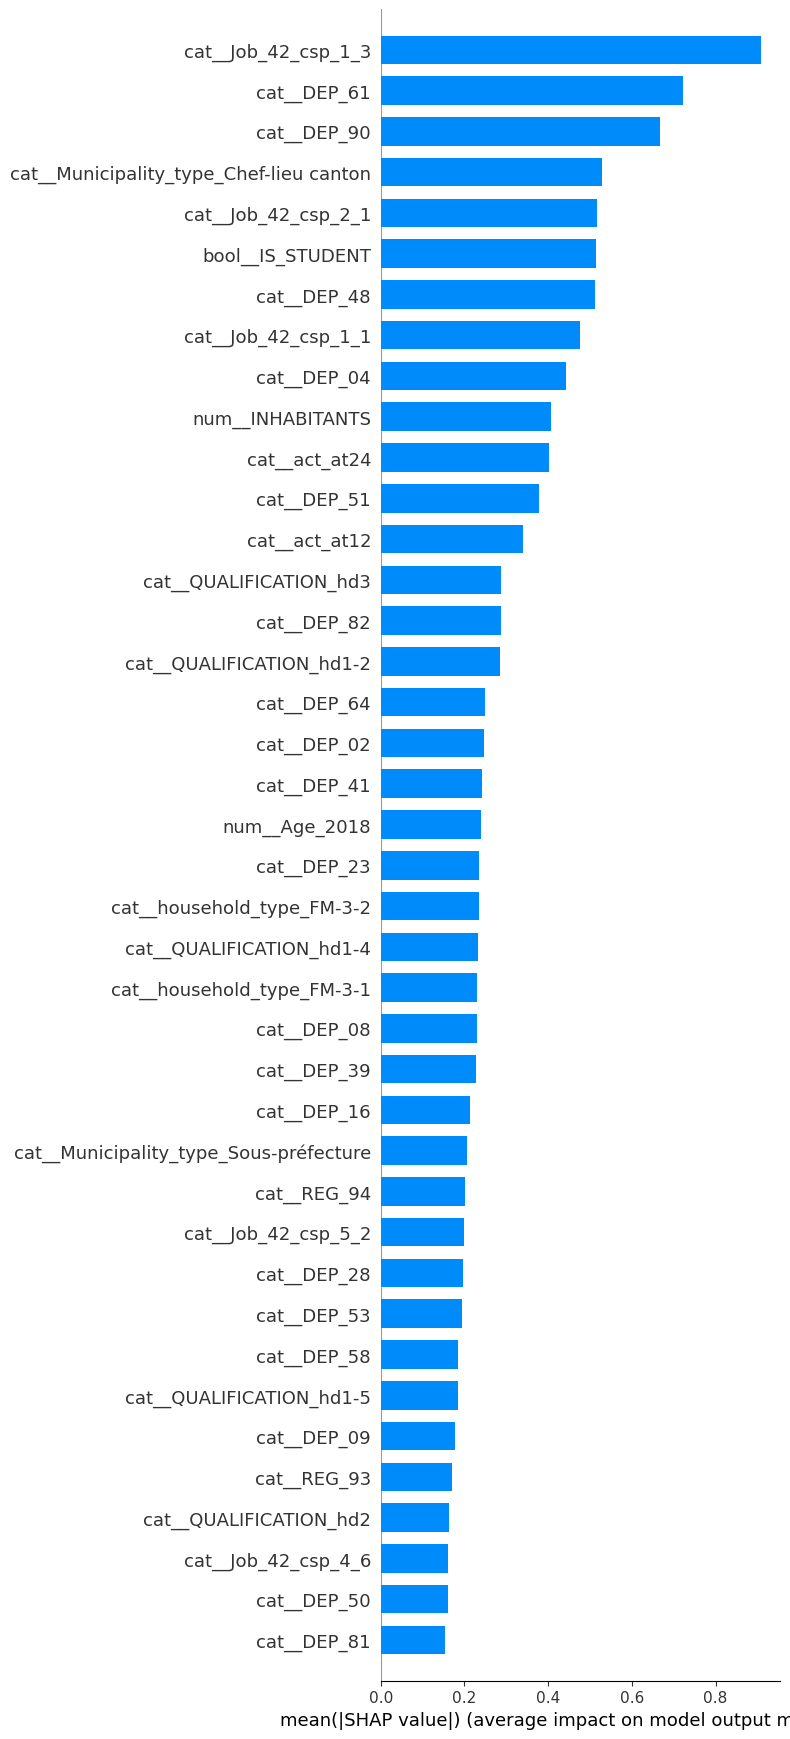

In [167]:
shap.summary_plot(
    shap_values_XGB_all,
    X_val_dense_XGB_all,
    plot_type="bar",
    max_display=40,  # Nombre de features à afficher    
    show=False
)

Tri des variables par show_feature_importances

Importances des features (selon feature_importances_ de XGBoost):
                                   feature  importance
0                            cat__sex_Male    0.054491
1                            cat__act_at24    0.046580
2                          cat__sex_Female    0.033966
3                         bool__IS_STUDENT    0.022631
4                            cat__act_at22    0.020853
5                            cat__act_at12    0.017019
6   cat__Municipality_type_Sous-préfecture    0.011680
7                            cat__act_at11    0.011533
8                      cat__Job_42_csp_1_1    0.009730
9                              cat__REG_32    0.009634
10                             cat__DEP_61    0.009621
11                             cat__DEP_67    0.009064
12                             cat__DEP_29    0.008876
13                  cat__QUALIFICATION_hd3    0.008813
14              cat__household_type_FM-2-0    0.008626
15                     cat__Job_42_csp_5_3    0.008129

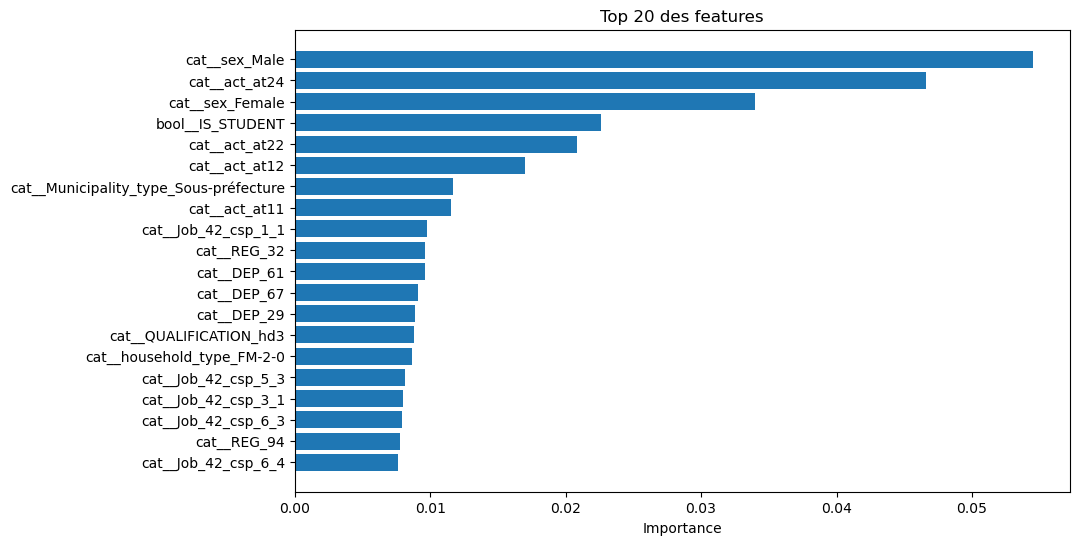

In [ ]:
from analysis.show_feature_importances import show_feature_importances

# Appel de la fonction utilisant feature_importances_ de XGBoost
importance_df = show_feature_importances(XGB_all_best, top_n=20, plot=True)

## Modèle *emploi*

In [6]:
from pipelines_preprocessing.pipeline_emploi import prepare_emploi_pipeline

# Utilisation de la fonction avec les données d'entrée
X_train, X_val, y_train, y_val = prepare_emploi_pipeline(
    learn_dataset=learn_dataset,
    learn_dataset_job=learn_dataset_job,
    #learn_dataset_emp=learn_dataset_emp,
    learn_dataset_sport=learn_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    test_size=0.2,  
    random_state=11,  
    stratify=True,  
    remove_columns=['Unique_id', 'Insee']  
)

In [25]:
# Vérifier si tous les Unique_id de learn_dataset_job sont dans learn_dataset_emp
unique_ids_jobs = set(learn_dataset_job['Unique_id'])
unique_ids_emp = set(learn_dataset_emp['Unique_id'])

# Identification des Unique_ids qui ne sont **pas** présents dans learn_dataset_emp
missing_ids = unique_ids_jobs - unique_ids_emp

# Affichage des résultats
if len(missing_ids) == 0:
    print("Tous les individus présents dans learn_dataset_job sont également dans learn_dataset_emp.")
else:
    print("Les individus suivants sont dans learn_dataset_job mais PAS dans learn_dataset_emp :")
    print(missing_ids)

Tous les individus présents dans learn_dataset_job sont également dans learn_dataset_emp.


Essai avec *learn_dataset_emp* non concluant (augmente l'overfitting).

#### RF *emploi*

Entraînement du modèle avec GridSearchCV...
Nombre de variables après preprocessing : 829

Meilleurs paramètres trouvés : {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}

Affichage des matrices de confusion...
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
train roc_auc: 0.9211
val roc_auc: 0.8345
train accuracy: 0.8410
Val accuracy: 0.8458
Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.77      0.80      1573
        True       0.85      0.90      0.87      2293

    accuracy                           0.85      3866
   macro avg       0.84      0.83      0.84      3866
weighted avg       0.85      0.85   

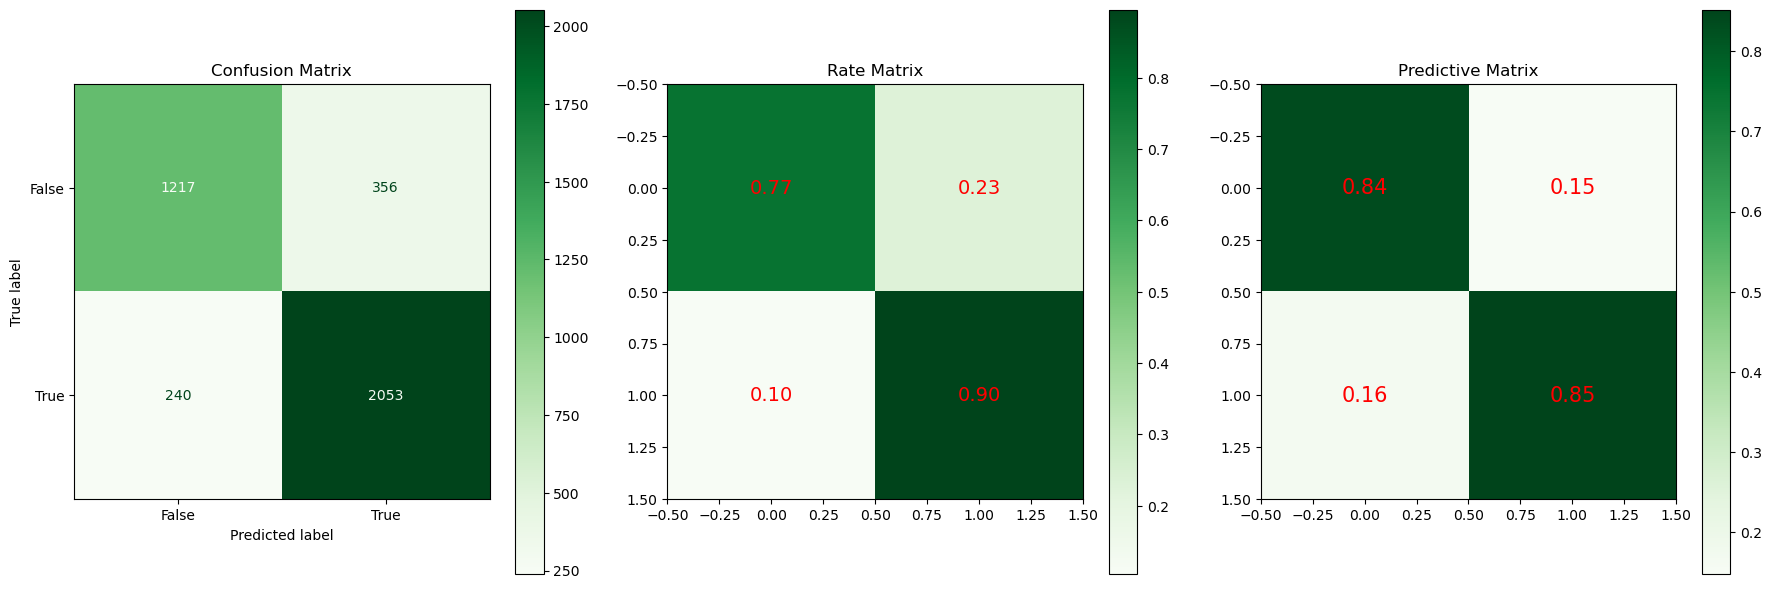

In [71]:
from models.pipeline_RF_emploi import RF_emploi

# Appel de la fonction pour entraîner et afficher les résultats
RF_emploi(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

### XGB *emploi*

Entraînement du modèle XGBoost avec GridSearchCV...
Nombre de variables après preprocessing : 829
Pipeline fitté sauvegardé sous 'models/fitted/XGB_emploi_fitted.pkl'

Affichage des matrices de confusion...
Best parameters: {'classifier__alpha': 0.1, 'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.4, 'classifier__lambda': 0.5, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.9}
train roc_auc: 0.9531
val roc_auc: 0.8793
train accuracy: 0.8811
Val accuracy: 0.8839
Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.86      0.86      1573
        True       0.90      0.90      0.90      2293

    accuracy                           0.88      3866
   macro avg       0.88      0.88      0.88      3866
weighted avg       0.88      0.88      0.88      3866

Matrice de confusion sauvegardée dans 'outputs\confusion_matrix\confusion_matrix_XGB_emploi.csv

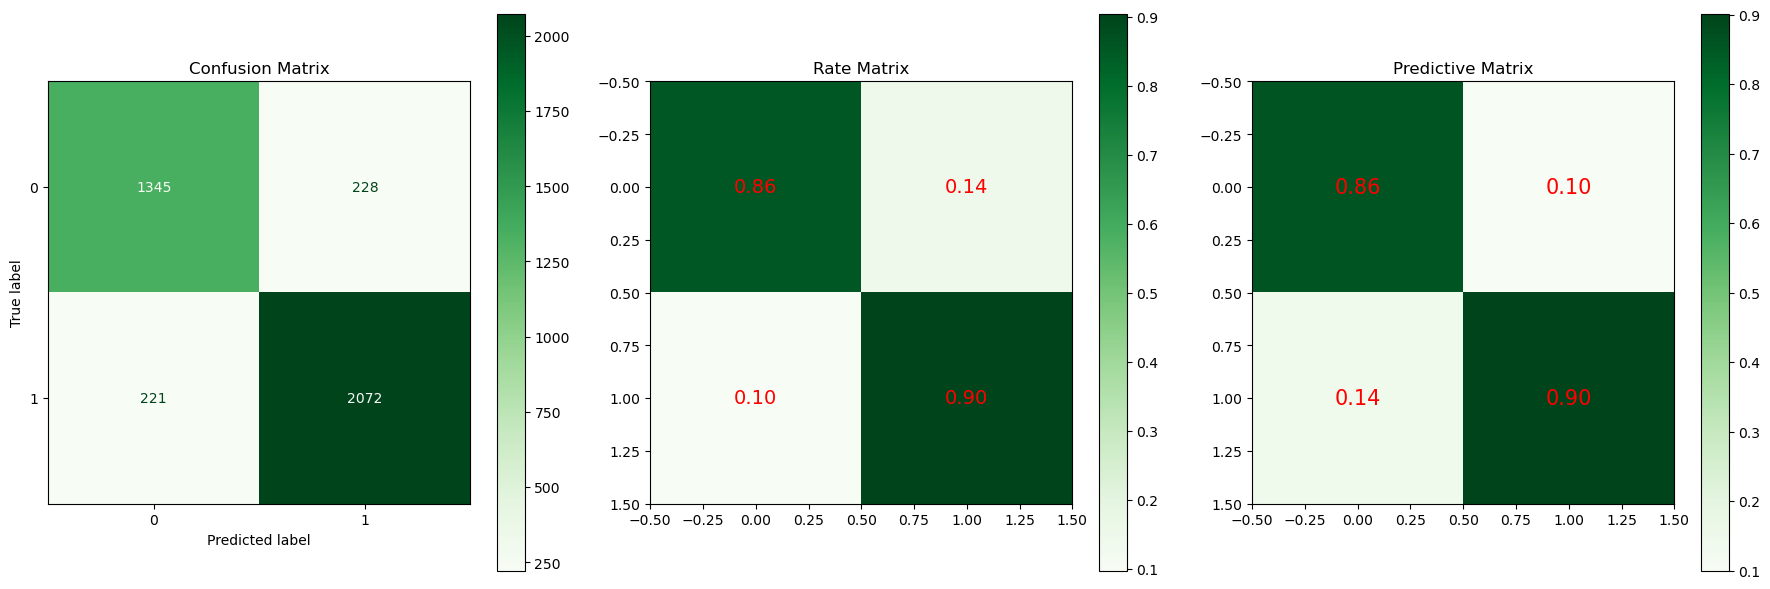

In [7]:
from models.pipeline_XGB_emploi import XGB_emploi

# Appel de la fonction
XGB_emploi(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

#### XGB *emploi* avec sélection de variables

In [135]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Isoler le modèle XGBoost formé
xgb_model = XGB_emploi_fitted.named_steps['classifier']

# Récupérer les noms des features AFTER preprocessing
feature_names = XGB_emploi_fitted.named_steps['preprocessor'].get_feature_names_out()

# Créer un DataFrame avec les importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': xgb_model.feature_importances_  # Utilise 'gain' par défaut
}).sort_values('Gain', ascending=False)

#  Afficher les top features
print("Top 20 des features par importance (gain):")
print(feature_importance_df.head(10))

Top 20 des features par importance (gain):
                                    Feature    Gain
48                            cat__sex_Male 0.07178
47                          cat__sex_Female 0.01666
824                        bool__IS_STUDENT 0.01390
714  cat__Municipality_type_Sous-préfecture 0.00970
141                         cat__Job_dep_82 0.00965
196                   cat__terms_of_emp_CDI 0.00811
478                     cat__Work_desc_561d 0.00698
815                             cat__REG_32 0.00669
20                      cat__Job_42_csp_6_4 0.00589
36                   cat__QUALIFICATION_hd3 0.00587


In [136]:
# Pipeline dédié pour les features triés par importance

from pipelines_preprocessing.preprocess_XGB_importance import preprocess_XGB_importance
n_features_to_keep = 200
# Appliquer la fonction
X_train_importance, X_val_importance = preprocess_XGB_importance(X_train,
X_val,
categorical_columns,
boolean_columns,
numeric_columns,
feature_importance_df,
n_features_to_keep)

Entraînement du modèle XGBoost avec GridSearchCV...

Affichage des matrices de confusion...
Best parameters: {'classifier__alpha': 0, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.5, 'classifier__lambda': 1, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
train roc_auc: 0.9515
val roc_auc: 0.8726
train accuracy: 0.8800
Val accuracy: 0.8782
Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.84      0.85      1573
        True       0.89      0.90      0.90      2293

    accuracy                           0.88      3866
   macro avg       0.87      0.87      0.87      3866
weighted avg       0.88      0.88      0.88      3866

Matrice de confusion sauvegardée dans 'outputs\confusion_matrix\confusion_matrix_XGB_emploi.csv'


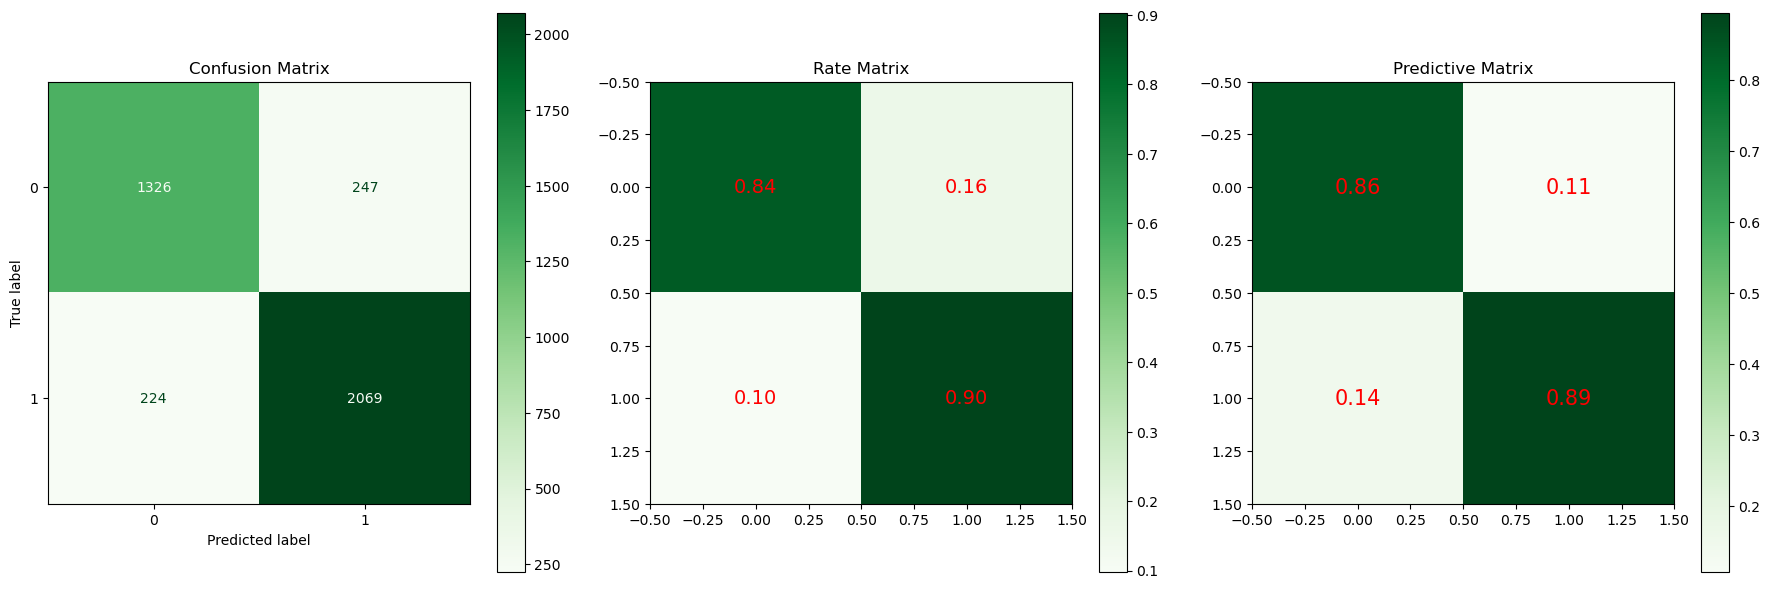

In [137]:
# Modèle emploi dédié pour les features triés par importance

from models.pipeline_XGB_emploi_importance import XGB_emploi_importance

# Appel de la fonction
XGB_emploi_importance(
    X_train=X_train_importance,
    y_train=y_train,
    X_val=X_val_importance,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

Commentaire

## Modèle *retired*

In [8]:
# pipeline préparation données full_retired

from pipelines_preprocessing.pipeline_retired import prepare_retired_pipeline

# Utilisation de la fonction avec les données d'entrée
X_train, X_val, y_train, y_val = prepare_retired_pipeline(
    learn_dataset=learn_dataset,
    learn_dataset_retired_jobs=learn_dataset_retired_jobs,
    learn_dataset_retired_pension=learn_dataset_retired_pension,
    learn_dataset_retired_former=learn_dataset_retired_former,
    learn_dataset_sport=learn_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    test_size=0.2,  # 20% pour la validation
    random_state=42,  # Fixe pour reproductibilité
    stratify=True,  # Stratification des données
    remove_columns=['Unique_id', 'Insee']  # Colonnes à supprimer
)


In [ ]:
# Vérifier si tous les Unique_id de learn_dataset_retired_jobs sont dans learn_dataset_retired_former
unique_ids_jobs = set(learn_dataset_retired_jobs['Unique_id'])
unique_ids_former = set(learn_dataset_retired_former['Unique_id'])

# Identification des Unique_ids qui ne sont **pas** présents dans learn_dataset_retired_former
missing_ids = unique_ids_jobs - unique_ids_former

# Affichage des résultats
if len(missing_ids) == 0:
    print("Tous les individus présents dans learn_dataset_retired_jobs sont également dans learn_dataset_retired_former.")
else:
    print("Les individus suivants sont dans learn_dataset_retired_jobs mais PAS dans learn_dataset_retired_former :")
    print(missing_ids)

### RF *retired*

Entraînement du modèle avec GridSearchCV...
Nombre de variables après preprocessing : 897

Meilleurs paramètres trouvés : {'classifier__class_weight': None, 'classifier__max_depth': 15, 'classifier__max_features': 0.4, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Meilleur score ROC-AUC : 0.9167749149390184

Affichage des matrices de confusion...
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 15, 'classifier__max_features': 0.4, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
train roc_auc: 0.9168
val roc_auc: 0.8291
train accuracy: 0.8413
Val accuracy: 0.8446
Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.78      0.78       791
        True       0.88      0.88      0.88      1467

    accuracy                           0.84      2258
   macro avg       0.83      0.83      0.83   

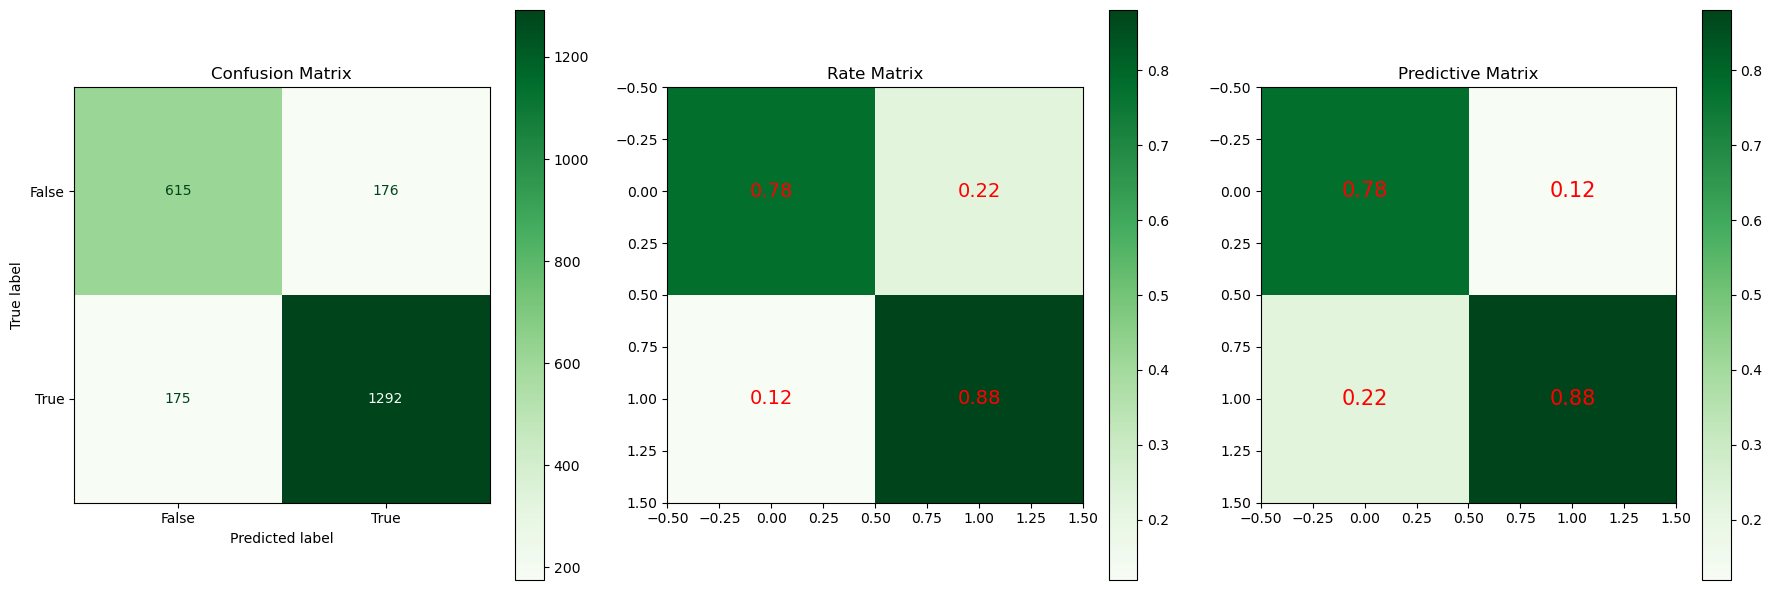

In [150]:
# RF sur data_full_retired

from models.pipeline_RF_retired import RF_retired


# Appel de l fonction pour entraîner et afficher les résultats
RF_retired(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

### XGB *retired*

Entraînement du modèle XGBoost avec GridSearchCV...
Nombre de variables après preprocessing : 897
Pipeline fitté sauvegardé sous 'models/fitted/XGB_retired_fitted.pkl'

Meilleurs paramètres trouvés : {'classifier__alpha': 0.1, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.5, 'classifier__lambda': 1, 'classifier__learning_rate': 0.04, 'classifier__max_depth': 10, 'classifier__n_estimators': 10000, 'classifier__subsample': 0.9}

Affichage des matrices de confusion...
Best parameters: {'classifier__alpha': 0.1, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.5, 'classifier__lambda': 1, 'classifier__learning_rate': 0.04, 'classifier__max_depth': 10, 'classifier__n_estimators': 10000, 'classifier__subsample': 0.9}
train roc_auc: 0.9522
val roc_auc: 0.8574
train accuracy: 0.8804
Val accuracy: 0.8738
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.80      0.82       791
        True       0.90      0.91    

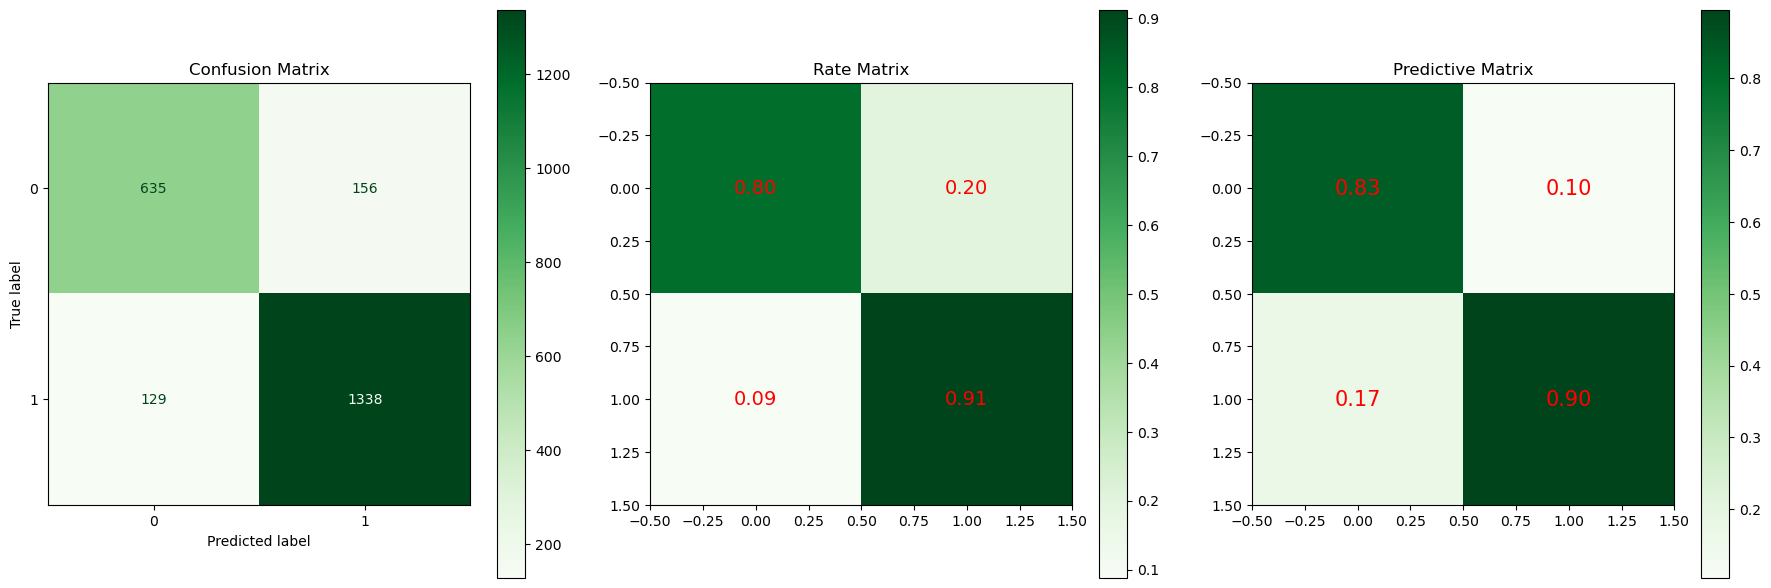

In [20]:
from models.pipeline_XGB_retired import XGB_retired

# Appel de la fonction
XGB_retired(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns= categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

## Modèle *nini*

Nous trions d'abord les données pour ne retenir que celles non-concernées par les modèles *emploi* et *retired* puis appliquons un modèle similaire à *all*.

In [4]:
from pipelines_preprocessing.pipeline_nini import prepare_nini_pipeline

X_train, X_val, y_train, y_val, learn_nini = prepare_nini_pipeline(
    data_learn=learn_dataset,
    learn_dataset_job=learn_dataset_job,
    learn_dataset_retired_jobs=learn_dataset_retired_jobs,
    learn_dataset_retired_former=learn_dataset_retired_former,
    learn_dataset_sport=learn_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    test_size=0.2,
    random_state=11,
    stratify=True,
    remove_columns=['Unique_id', 'Insee']
)

print(f"X_train nini : {X_train.shape}")

X_train nini : (15543, 12)


### RF *nini*

Entraînement du modèle avec GridSearchCV...

Meilleurs paramètres trouvés : {'classifier__class_weight': None, 'classifier__max_depth': 17, 'classifier__max_features': 0.2, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 7, 'classifier__n_estimators': 200}
Meilleur score ROC-AUC : 0.9303085768061878

Affichage des matrices de confusion...
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 17, 'classifier__max_features': 0.2, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 7, 'classifier__n_estimators': 200}
Cross-validation roc_auc: 0.9303085768061878
Test roc_auc: 0.7393293633472594
Cross-validation Accuracy (moyenne): 0.8970966768171864
Test accuracy: 0.8989284679988416
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.50      0.62       553
        True       0.91      0.97      0.94      2900

    accuracy                           0.90      3453
   macro avg

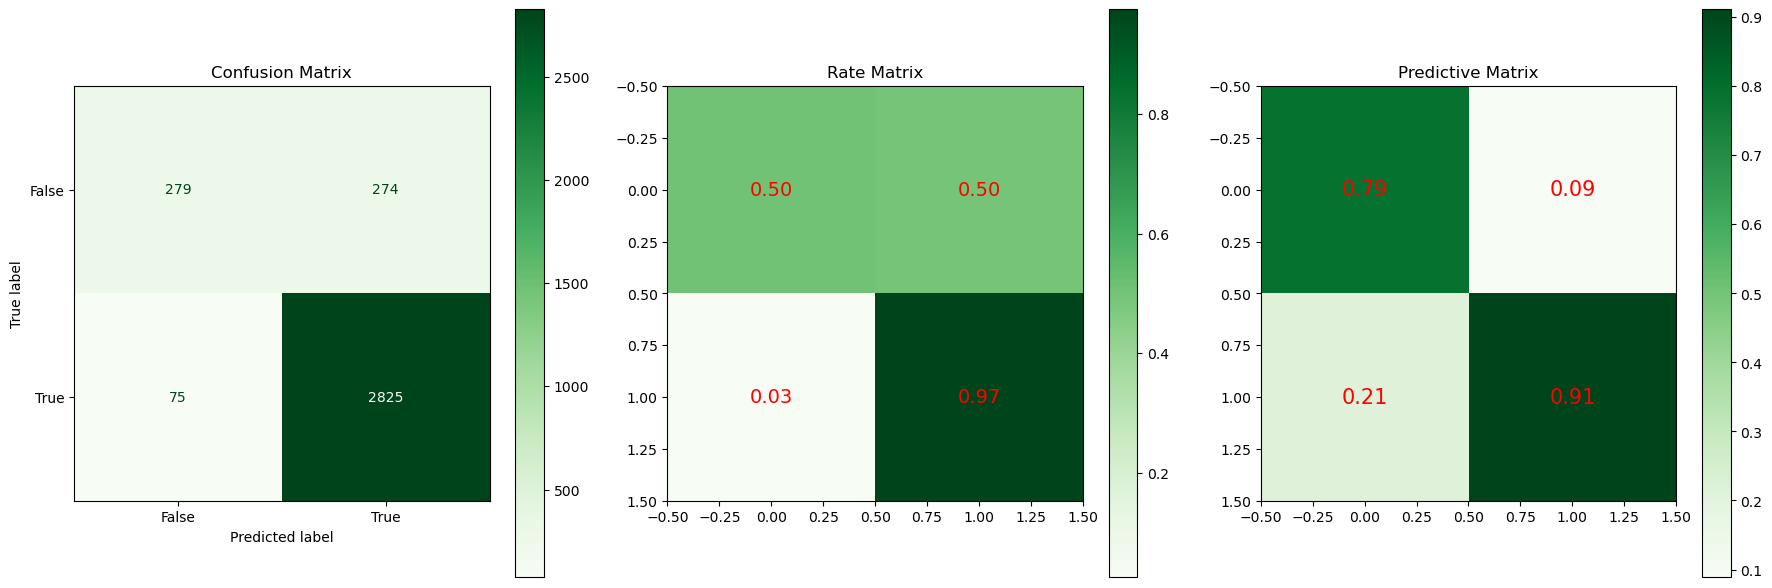

In [29]:
# RF sur data_full_retired

from models.pipeline_RF_nini import RF_nini

# Appel de la fonction pour entraîner et afficher les résultats
RF_nini(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

### XGB *nini*

Entraînement du modèle XGBoost avec GridSearchCV...
Nombre de variables après preprocessing : 277
Pipeline fitté sauvegardé sous 'models/fitted/XGB_nini_fitted.pkl'

Affichage des matrices de confusion...
Best parameters: {'classifier__alpha': 0.1, 'classifier__colsample_bytree': 0.5, 'classifier__gamma': 0.6, 'classifier__lambda': 0.1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.9}
train roc_auc: 0.9516
val roc_auc: 0.8278
train accuracy: 0.9110
Val accuracy: 0.9197
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.69      0.75       664
        True       0.94      0.97      0.95      3222

    accuracy                           0.92      3886
   macro avg       0.88      0.83      0.85      3886
weighted avg       0.92      0.92      0.92      3886

Matrice de confusion sauvegardée dans 'outputs\confusion_matrix\confusion_matrix_XGB_nini.csv'


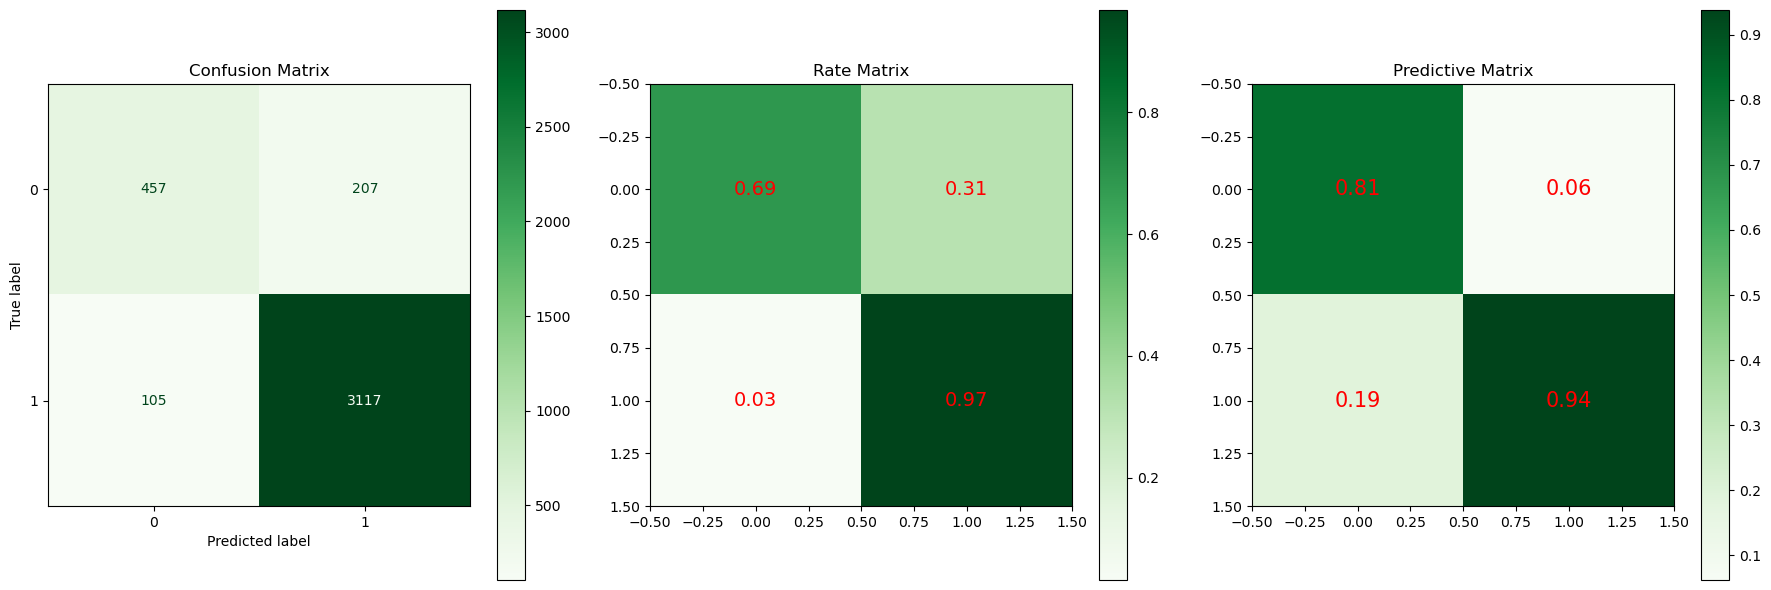

In [5]:
from models.pipeline_XGB_nini import XGB_nini

# Appel de la fonction
XGB_nini(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns= categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns
)

## *nini* variante
Ici, nous récupérons les observations non-concernées par *emploi* et *retired* dans les résultats du modèle *all*. 

In [ ]:
# Récupération des index des lignes pour le modèle nini

from pipelines_preprocessing.pipeline_all import prepare_all_pipelin

# Utilisation de la fonction avec les données d'entrée
X_train, X_val, y_train, y_val = all_pipeline(
    learn_dataset=learn_dataset,
    learn_dataset_sport=learn_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    test_size=0.2,  
    random_state=11,  
    stratify=True,  
    remove_columns=['Insee']  
)

from pipelines_preprocessing.pipeline_extract_Unique_id_nini import extract_nini_columns

columns_nini = extract_nini_columns(
    data_learn=learn_dataset,
    learn_dataset_job=learn_dataset_job,
    learn_dataset_retired_jobs=learn_dataset_retired_jobs,
    learn_dataset_retired_former=learn_dataset_retired_former,
    learn_dataset_sport=learn_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    remove_columns=['Unique_id', 'Insee']
)

print(f"X_train nini : {X_train.shape}")

X_train nini : (40035, 13)


### RF nini variante

Entraînement du modèle avec GridSearchCV...

Meilleurs paramètres trouvés : {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Meilleur score ROC-AUC (cross-validation) : 0.9264537433071304

Evaluation du modèle sur les données de validation (filtrées avec columns_nini)...
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Cross-validation roc_auc: 0.9264537433071304
Test roc_auc: 0.799965244750128
Cross-validation Accuracy (moyenne): 0.8598726114649681
Test accuracy: 0.9054415700267618
Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.65      0.68       519
        True       0.94      0.95      0.94      2844

  

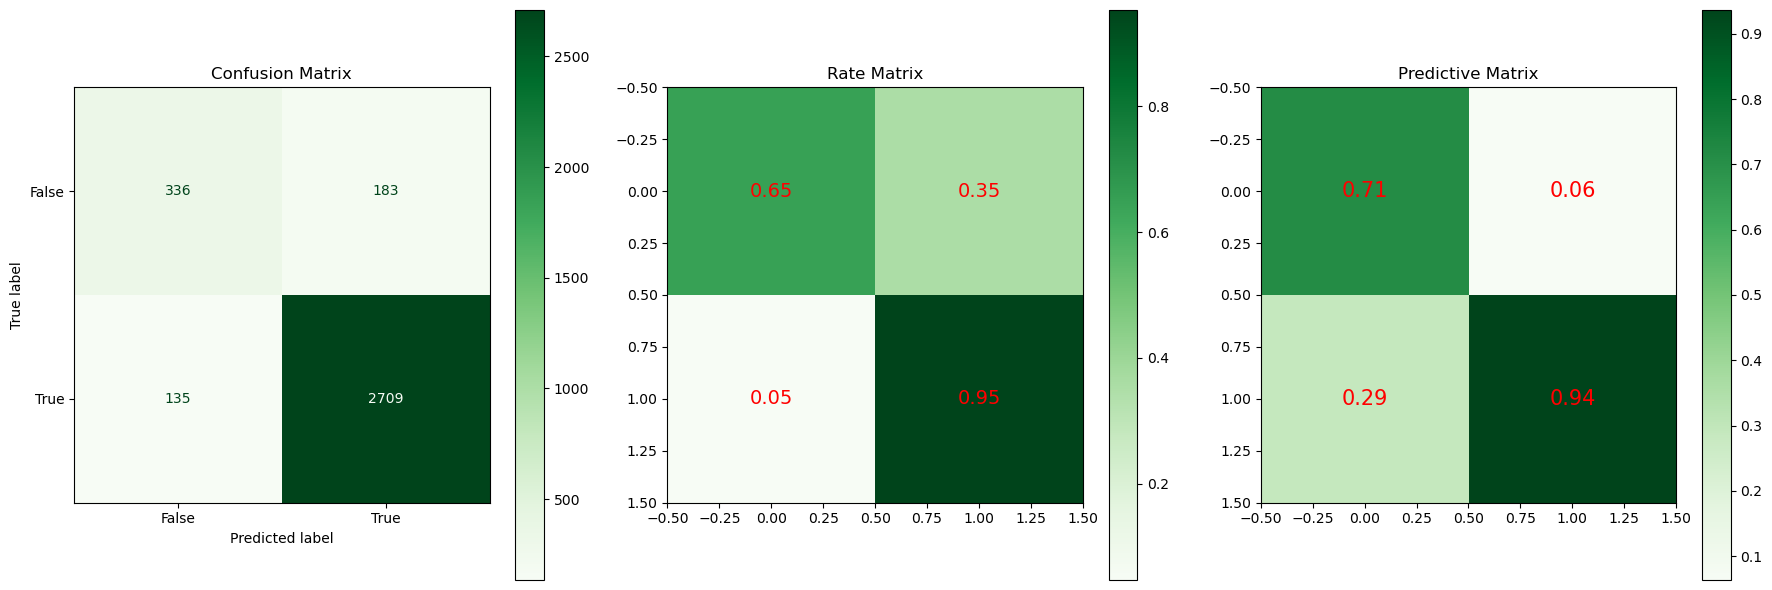

In [ ]:
from models.pipeline_RF_all_extract_nini import RF_all_extract_nini

RF_all_extract_nini(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns,
    columns_nini=columns_nini  
)


### XGB nini variante

Entraînement du modèle XGBoost avec GridSearchCV...

Meilleurs paramètres trouvés : {'classifier__alpha': 0, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.5, 'classifier__lambda': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Meilleur score ROC-AUC (cross-validation) : 0.9472174935581199

Evaluation du modèle sur les données de validation (filtrées avec columns_nini)...
Best parameters: {'classifier__alpha': 0, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.5, 'classifier__lambda': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Cross-validation roc_auc: 0.9472174935581199
Test roc_auc: 0.8188885636935685
Cross-validation Accuracy (moyenne): 0.8814037716997628
Test accuracy: 0.9134701159678859
Classification Report:
              precision    recall  f1-score   support

       False       0.74     

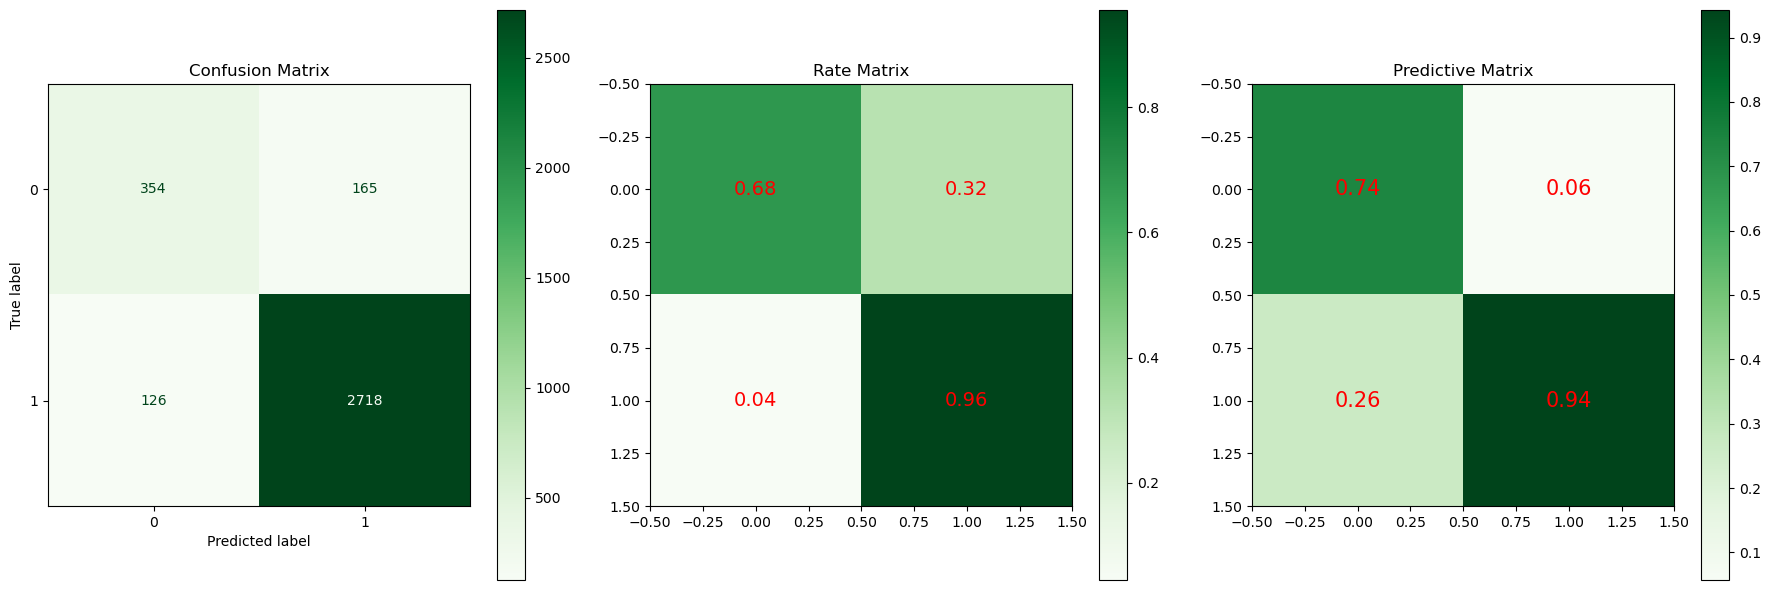

In [ ]:
from models.pipeline_XGB_all_extract_nini import XGB_all_extract_nini

XGB_all_extract_nini(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical_columns=categorical_columns,
    boolean_columns=boolean_columns,
    numeric_columns=numeric_columns,
    columns_nini=columns_nini  
)

Résultats très proches de ceux obtenus avec le modèle *nini* 'classique' mais inférieur.

# Prédictions 

### Prédictions *emploi* 

In [9]:
from pipelines_preprocessing.pipeline_emploi_test import preprocess_emploi_test_data

# Appeler la fonction pour transformer les données de test
X_test_emploi_preprocessed = preprocess_emploi_test_data(
    test_dataset=test_dataset,
    test_dataset_job=test_dataset_job,  
    test_dataset_sport=test_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    remove_columns=['Unique_id', 'Insee']
)

# Afficher un résumé des données transformées
print(f"X_test_emploi_preprocessed : {X_test_emploi_preprocessed.shape}")

X_test_emploi_preprocessed : (19353, 22)


In [10]:
import joblib
# Charger le pipeline
XGB_emploi_fitted = joblib.load("models/fitted/XGB_emploi_fitted.pkl")

# Faire une prédiction directement
y_pred_emploi = XGB_emploi_fitted.predict(X_test_emploi_preprocessed)  # Prédiction 
#y_pred_emploi = XGB_emploi_fitted.predict(X_test_emploi_preprocessed.iloc[[0]])              # pour test avec une seule ligne de données --> OK
y_pred_emploi_prob = XGB_emploi_fitted.predict_proba(X_test_emploi_preprocessed)  # Probabilités 

unique_id = test_dataset_job['Unique_id']
# unique_id = test_dataset_job.iloc[[0]]['Unique_id']                                         # pour test avec une seule ligne de données --> OK

# Étape 2 : Créer un DataFrame combinant Unique_id et y_pred_emploi_prov
y_pred_emploi = pd.DataFrame({
    'Unique_id': unique_id,
    'Prediction': y_pred_emploi
})

### Prédictions *retired*

In [11]:
from pipelines_preprocessing.pipeline_retired_test import preprocess_retired_test_data

X_test_retired_preprocessed, test_retired_preprocessed_Unique_id = preprocess_retired_test_data(
    test_dataset=test_dataset,
    test_dataset_retired_jobs=test_dataset_retired_jobs,
    test_dataset_retired_pension=test_dataset_retired_pension,
    test_dataset_retired_former=test_dataset_retired_former,
    test_dataset_sport=test_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    remove_columns=['Unique_id', 'Insee']
)

print(f"X_test_retired_preprocessed : {X_test_retired_preprocessed.shape}")

X_test_retired_preprocessed : (11138, 26)


In [15]:
import joblib
# Charger le pipeline
XGB_retired_fitted = joblib.load("models/fitted/XGB_retired_fitted.pkl")

# Faire une prédiction directement
y_pred_retired = XGB_retired_fitted.predict(X_test_retired_preprocessed)  # Prédiction 
#y_pred_retired = XGB_retired_fitted.predict(X_test_retired_preprocessed.iloc[[0]])              # pour test avec une seule ligne de données --> OK
y_pred_retired_prob = XGB_retired_fitted.predict_proba(X_test_retired_preprocessed)  # Probabilités 

unique_id = test_retired_preprocessed_Unique_id['Unique_id']
# unique_id = test_retired_preprocessed_Unique_id.iloc[[0]]['Unique_id']                            # pour test avec une seule ligne de données --> OK

# Étape 2 : Créer un DataFrame combinant Unique_id et y_pred_retired_prov
y_pred_retired = pd.DataFrame({
    'Unique_id': unique_id,
    'Prediction': y_pred_retired
})

### Prédicitons *nini*

In [13]:
from pipelines_preprocessing.pipeline_nini_test import preprocess_nini_test_data


X_test_nini_preprocessed, test_nini_preprocessed_Unique_id = preprocess_nini_test_data(
    test_dataset=test_dataset,
    y_pred_emploi=y_pred_emploi,
    y_pred_retired=y_pred_retired,
    test_dataset_sport=test_dataset_sport,
    city_adm=city_adm,
    departments=departments,
    city_pop=city_pop,
    remove_columns=['Unique_id', 'Insee']
)

print(f"X_test_nini_preprocessed : {X_test_nini_preprocessed.shape}")

X_test_nini_preprocessed : (19552, 12)


In [16]:
import joblib
# Charger le pipeline
XGB_nini_fitted = joblib.load("models/fitted/XGB_nini_fitted.pkl")

# Faire une prédiction directement
y_pred_nini = XGB_nini_fitted.predict(X_test_nini_preprocessed)            # Prédiction 
# y_pred_nini = XGB_nini_fitted.predict(X_test_nini_preprocessed.iloc[[0]])              # pour test avec une seule ligne de données --> OK
y_pred_nini_prob = XGB_nini_fitted.predict_proba(X_test_nini_preprocessed)   # Probabilités 

unique_id = test_nini_preprocessed_Unique_id['Unique_id']
# unique_id = test_nini_preprocessed_Unique_id.iloc[[0]]['Unique_id']                   # pour test avec une seule ligne de données --> OK

# Étape 2 : Créer un DataFrame combinant Unique_id et y_pred_nini_prov
y_pred_nini = pd.DataFrame({
    'Unique_id': unique_id,
    'Prediction': y_pred_nini
})

### Réunir les résultats

In [22]:
import os

# Fusionner verticalement les DataFrames
y_pred_final = pd.concat([y_pred_emploi, y_pred_retired, y_pred_nini], ignore_index=True)

# Trier par ordre croissant selon la variable Unique_id
y_pred_final = y_pred_final.sort_values(by='Unique_id').reset_index(drop=True)

# Transformer la variable target dans la forme originale : remplacer 1 par 'T' et 0 par 'F' dans la colonne Prediction
y_pred_final['Prediction'] = y_pred_final['Prediction'].map({1: 'T', 0: 'F'})

# Sauvegarder le DataFrame en format CSV
y_pred_final.to_csv("data/predictions/y_pred_final.csv", index=False)

In [ ]:
# transformation au format requis du fichier des prédictions et sauvegarder à la racine du projet.
import pandas as pd

df = pd.read_csv('data/predictions/y_pred_final.csv')
predictions = df.rename(columns={'Prediction': 'target'})
predictions.to_csv('predictions.csv', index=False, sep=',')

### Accuracy attendue sur les prévisions

In [24]:
# accuracy attendue sur les prédictions

import pandas as pd
import numpy as np
import os

# Chemins vers vos matrices de confusion sauvegardées
matrix_files = [
    os.path.join("outputs", "confusion_matrix", "confusion_matrix_XGB_emploi.csv"),
    os.path.join("outputs", "confusion_matrix", "confusion_matrix_XGB_retired.csv"),
    os.path.join("outputs", "confusion_matrix", "confusion_matrix_XGB_nini.csv"),
]

# Charger les matrices comme DataFrames et nettoyer
matrices = [
    pd.read_csv(f, header=None, skiprows=1).values for f in matrix_files
]

# Additionner les matrices
total_matrix = np.sum(matrices, axis=0)

# Calcul de l'accuracy globale
correct_predictions = np.trace(total_matrix)  # Somme de la diagonale
total_predictions = np.sum(total_matrix)      # Somme de tous les éléments

accuracy = correct_predictions / total_predictions
print(f"Accuracy globale des 3 modèles : {accuracy:.4f}")

Accuracy globale des 3 modèles : 0.8955


# Données géographique (non utilisée pour les prédictions)


Nous créons une nouvelle variable *distance_pref* pour chaque individu.

In [ ]:
# extraire les données géographiques des prefectures 

pref = city_adm
pref = pref.drop(columns=["Nom de la commune", "DEP"])
pref = pref[pref["Municipality_type"] == "Préfecture"]
pref = pref.merge(city_loc[["Insee", "X", "Y"]], on="Insee", how="left")
pref = pref.rename(columns={"X": "X_pref", "Y": "Y_pref"})

In [ ]:
# Créer un dataset dédié aux distances à partir de learn_dataset

learn_dataset_distance = learn_dataset
learn_dataset_distance = learn_dataset_distance[["Insee", "target"]]
learn_dataset_distance = learn_dataset_distance.merge(city_loc[["Insee", "X", "Y"]], on="Insee", how="left")

In [ ]:
# Étape 1 : Extraire les deux premiers chiffres de `Insee` dans les deux datasets
pref["Insee_prefix"] = pref["Insee"].astype(str).str[:2]  # Extrait les 2 premiers chiffres
learn_dataset_distance["Insee_prefix"] = learn_dataset_distance["Insee"].astype(str).str[:2]

# Étape 2 : Joindre les datasets sur les deux premiers chiffres ("Insee_prefix")
# Utilisation d'un `merge` pour ajouter X_pref et Y_pref au dataset `learn_dataset_distance`.
learn_dataset_distance = learn_dataset_distance.merge(
    pref[["Insee_prefix", "X_pref", "Y_pref"]],  # Colonnes à joindre
    on="Insee_prefix",  # Clé utilisée pour la correspondance
    how="left"  # On garde toutes les lignes de `learn_dataset_distance`
)

# Suppression de la colonne temporaire `Insee_prefix` si elle n'est plus nécessaire
learn_dataset_distance.drop(columns=["Insee_prefix"], inplace=True)

In [ ]:
# calcul de la distance à la préfecture
import numpy as np
learn_dataset_distance['distance_pref'] = np.sqrt(
    (learn_dataset_distance['X'] - learn_dataset_distance['X_pref'])**2 +
    (learn_dataset_distance['Y'] - learn_dataset_distance['Y_pref'])**2
)

learn_dataset_distance['distance_pref'] = learn_dataset_distance['distance_pref'] / 1000
# Transformer T/F en 1/0
learn_dataset_distance['target'] = learn_dataset_distance['target'].replace({'T': 1, 'F': 0})
# Remplacer les nan par la valeur zéro pour distance_pref
learn_dataset_distance['distance_pref'] = learn_dataset_distance['distance_pref'].fillna(0)

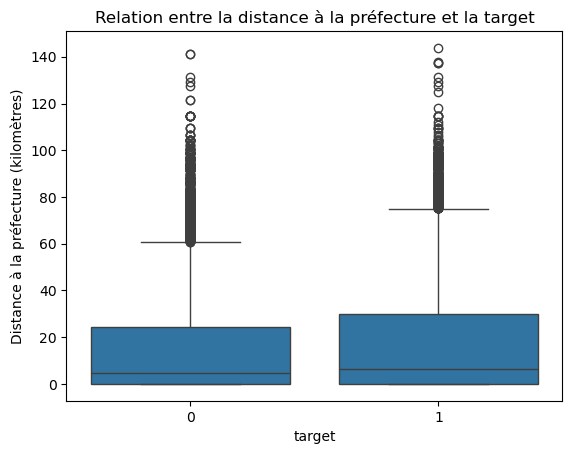

In [ ]:
# box plot distance à la prefecture selon la target
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot
sns.boxplot(x='target', y='distance_pref', data=learn_dataset_distance)
plt.title('Relation entre la distance à la préfecture et la target')
plt.xlabel('target')
plt.ylabel('Distance à la préfecture (kilomètres)')
plt.show()

On observe une différence mais faible et sans doute peu exploitable.

C:\Users\olivi\AppData\Local\Temp\ipykernel_86612\1846382937.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='target', y='distance_pref', data=learn_dataset_distance, inner='quartile', palette="muted")


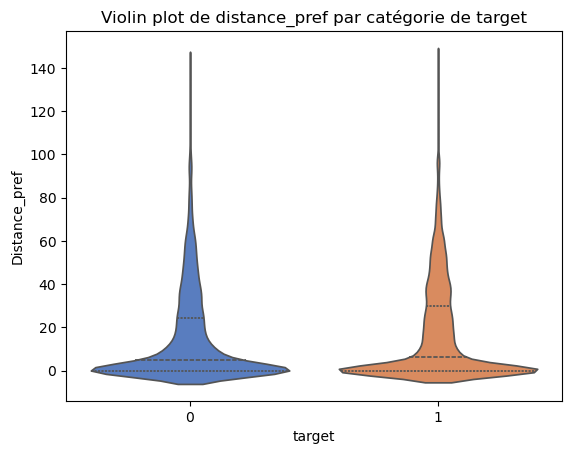

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot pour visualiser la distribution de distance_pref par catégorie de target
sns.violinplot(x='target', y='distance_pref', data=learn_dataset_distance, inner='quartile', palette="muted")

# Ajouter un titre au graphique
plt.title("Violin plot de distance_pref par catégorie de target")
plt.xlabel("target")
plt.ylabel("Distance_pref")

# Afficher le graphique
plt.show()

Pas de différence significative entre les deux distributions.

In [55]:
from scipy.stats import pointbiserialr

# Calcul du coefficient de corrélation point bisérial
corr, p_value = pointbiserialr(learn_dataset_distance['target'], learn_dataset_distance['distance_pref'])

print(f"Corrélation point bisérial : {corr:.4f}")
print(f"p-valeur : {p_value:.4f}")

Corrélation point bisérial : 0.0435
p-valeur : 0.0000


Très faible corrélation entre distance_pref et la target.

In [60]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(learn_dataset_distance['distance_pref'], learn_dataset_distance['target'])
print(f"Corrélation de Spearman : {corr:.4f}, p-valeur : {p_value:.4f}")


Corrélation de Spearman : 0.0327, p-valeur : 0.0000


Confirme la très faible corrélation entre *distance_pref* et la target.

In [ ]:
# modèle arbre sur l'unique variable distance_pref

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Diviser les données
X = learn_dataset_distance[['distance_pref']]
y = learn_dataset_distance['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer et entraîner le modèle
model = DecisionTreeClassifier(max_depth=3)  # Limite la profondeur pour éviter le sur-ajustement
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe 1
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC score : {auc_score:.4f}")

AUC-ROC score : 0.5420


AUC_ROC score très faible.
Nous avons, comme dernière tentative avec *distance_pref*, ajouté la variable dans le modèle *all*, sans résultat probant.